In [1]:
import gc
import os
import glob
import zipfile
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

import cv2
import PIL
from PIL import ImageOps, ImageFilter, ImageDraw

In [2]:
device_name = tf.test.gpu_device_name() #GPU Run Check
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Mind_Elevation/splitlabel/'
IMG_PATH = '/content/drive/My Drive/Colab Notebooks/Mind_Elevation/467case_cut/'
os.listdir(DATA_PATH)

['뿌리-부재2.xlsx',
 '크기-나무-크다.xlsx',
 'test_가지-부재.xlsx',
 '위치-나무-정중앙.xlsx',
 'train_위치-나무-정중앙.xlsx',
 '수관-공 모양.xlsx',
 'sub_가지-부재.xlsx',
 '크기-사람-작다.xlsx',
 '위치-사람-정중앙.xlsx',
 'train_위치-나무-아래.xlsx',
 'sub_기둥-상처, 옹이구멍.xlsx',
 'train_뿌리-부재2.xlsx',
 '기둥-옹이구멍 안 동물.xlsx',
 'test_뿌리-부재1.xlsx',
 'train_수관-공 모양.xlsx',
 'sub_위치-나무-위.xlsx',
 '손-정교함(손톱, 주름).xlsx',
 '위치-나무-위.xlsx',
 'train_가지-부재.xlsx',
 '머리카락-윤곽선(검게 표현되지 않은 긴 머리).xlsx',
 '가지-부재.xlsx',
 '문-격자무늬 창.xlsx',
 '절단-나무-위.xlsx',
 'sub_위치-나무-아래.xlsx',
 'test_절단-나무-오른쪽.xlsx',
 'sub_뿌리-부재1.xlsx',
 'test_위치-나무-아래.xlsx',
 '손-부재.xlsx',
 '창문-많다.xlsx',
 'train_가지-옆으로 벌어짐.xlsx',
 '위치-사람-오른쪽.xlsx',
 'train_기둥-상처, 옹이구멍.xlsx',
 'test_기둥-상처, 옹이구멍.xlsx',
 '지면선-벽 밑면 있지만 지면 없음.xlsx',
 'train_크기-나무-크다.xlsx',
 'sub_절단-나무-위.xlsx',
 'sub_가지-아래로 늘어진 가지.xlsx',
 'train_위치-나무-위.xlsx',
 '창문-격자무늬.xlsx',
 'test_절단-나무-위.xlsx',
 '다리-넓게 벌림.xlsx',
 'test_수관-공 모양.xlsx',
 '위치-나무-아래.xlsx',
 '다리-앉아있음.xlsx',
 '위치-집-아래.xlsx',
 'sub_절단-나무-오른쪽.xlsx',
 'sub_기둥-옹이구멍 안 동물.xlsx',
 '가지-아

In [0]:
tree = ['크기-나무-크다',
           '위치-나무-정중앙',
            '위치-나무-아래',
            '위치-나무-위',
            '절단-나무-위',
            '절단-나무-오른쪽',
            '가지-아래로 늘어진 가지',
            # '뿌리-부재1',
            '수관-공 모양',
            '기둥-옹이구멍 안 동물',
            '가지-부재',
            '뿌리-부재2',
            '가지-옆으로 벌어짐',
            '기둥-상처, 옹이구멍'
            ]

In [0]:
# TRAIN_CROP_PATH = '/Users/Il-hyeon/Documents/Data/train_crop'
TRAIN_IMG_PATH = os.path.join(IMG_PATH, 'tree')

df_train = []
df_test = []
for excel_name in tree:
    df_train.append(pd.read_excel(os.path.join(DATA_PATH, 'train_' + excel_name + '.xlsx')))
    df_train[tree.index(excel_name)]['data'] = df_train[tree.index(excel_name)].data.apply(lambda x: f'{x:0>4}')
    df_test.append(pd.read_excel(os.path.join(DATA_PATH, 'test_' + excel_name + '.xlsx')))
    df_test[tree.index(excel_name)]['data'] = df_test[tree.index(excel_name)].data.apply(lambda x: f'{x:0>4}')

In [7]:
for i in range(len(tree)):
    print(df_train[i].head())
    print(df_test[i].head())

   Unnamed: 0        data  크기-나무-크다
0         174  0200_T.jpg         1
1         272  0317_T.jpg         1
2         170  0196_T.jpg         1
3           8  0009_T.jpg         1
4         214  0245_T.jpg         1
   Unnamed: 0        data  크기-나무-크다
0         433  0502_T.jpg         1
1          71  0072_T.jpg         0
2           7  0008_T.jpg         1
3         352  0421_T.jpg         1
4         444  0513_T.jpg         1
   Unnamed: 0        data  위치-나무-정중앙
0         220  0252_T.jpg          0
1         363  0432_T.jpg          0
2         394  0463_T.jpg          0
3         142  0159_T.jpg          0
4          41  0042_T.jpg          0
   Unnamed: 0        data  위치-나무-정중앙
0         442  0511_T.jpg          0
1         324  0393_T.jpg          0
2         159  0182_T.jpg          0
3         269  0312_T.jpg          0
4         101  0102_T.jpg          0
   Unnamed: 0        data  위치-나무-아래
0         253  0292_T.jpg         0
1         375  0444_T.jpg         1
2          69  0

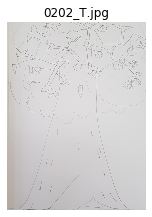

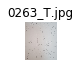

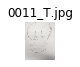

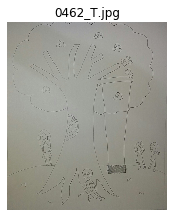

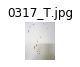

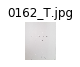

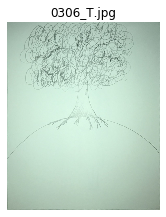

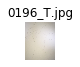

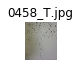

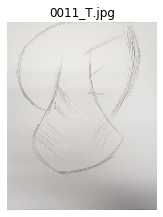

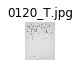

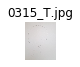

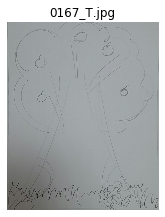

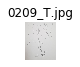

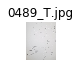

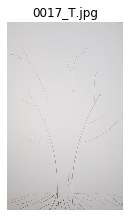

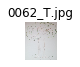

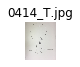

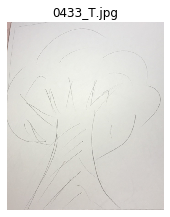

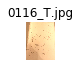

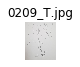

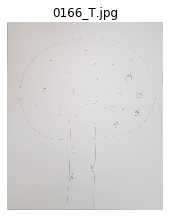

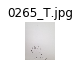

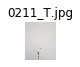

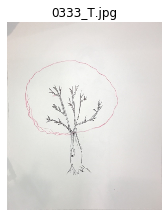

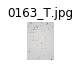

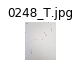

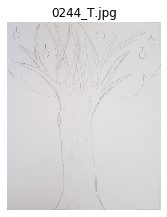

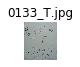

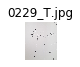

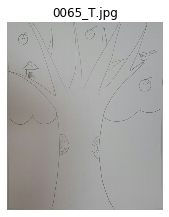

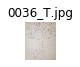

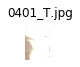

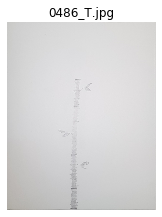

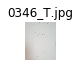

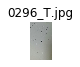

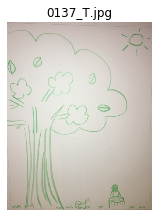

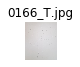

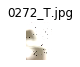

In [8]:
for i in range(len(df_train)):
    tmp_img = df_train[i]['data'][100:103]
    plt.figure(figsize=(12, 20))
    
    for num, f_name in enumerate(tmp_img):
        img = PIL.Image.open(os.path.join(TRAIN_IMG_PATH, f_name))
        plt.subplot(5, 2, 2*num + 1)
        plt.title(f_name)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [9]:
from sklearn.model_selection import train_test_split

X_train = []
X_val = []

for i, data in enumerate(tree):
    df_train[i][data] = df_train[i][data].astype('str')
    y = df_train[i][data]
    df_train[i] = df_train[i][['data', data]]
    df_test[i] = df_test[i][['data']]
    
    its = np.arange(df_train[i].shape[0])
    train_idx, val_idx = train_test_split(its, test_size = 0.2, random_state = 42, stratify=y)
    
    X_train.append(df_train[i].iloc[train_idx, :])
    X_val.append(df_train[i].iloc[val_idx, :])
    
    print(data)
    print(X_train[i].shape)
    print(X_val[i].shape)
    print(df_train[i].shape)
    print(df_test[i].shape)
    print('='*20)

크기-나무-크다
(298, 2)
(75, 2)
(373, 2)
(94, 1)
위치-나무-정중앙
(298, 2)
(75, 2)
(373, 2)
(94, 1)
위치-나무-아래
(298, 2)
(75, 2)
(373, 2)
(94, 1)
위치-나무-위
(298, 2)
(75, 2)
(373, 2)
(94, 1)
절단-나무-위
(298, 2)
(75, 2)
(373, 2)
(94, 1)
절단-나무-오른쪽
(298, 2)
(75, 2)
(373, 2)
(94, 1)
가지-아래로 늘어진 가지
(298, 2)
(75, 2)
(373, 2)
(94, 1)
수관-공 모양
(298, 2)
(75, 2)
(373, 2)
(94, 1)
기둥-옹이구멍 안 동물
(298, 2)
(75, 2)
(373, 2)
(94, 1)
가지-부재
(298, 2)
(75, 2)
(373, 2)
(94, 1)
뿌리-부재2
(298, 2)
(75, 2)
(373, 2)
(94, 1)
가지-옆으로 벌어짐
(298, 2)
(75, 2)
(373, 2)
(94, 1)
기둥-상처, 옹이구멍
(298, 2)
(75, 2)
(373, 2)
(94, 1)


In [0]:
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [11]:
epochs = 20
batch_size = 32
img_size = (224, 224)
train_datagen = ImageDataGenerator(
    horizontal_flip = False, 
    vertical_flip = False, 
    rotation_range = 3,   # image random roation
    preprocessing_function = preprocess_input
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = []
validation_generator = []
test_generator = []

nb_train_samples = []
nb_validation_samples = []
nb_test_samples = []

for i, num in enumerate(tree):
        nb_train_samples.append(len(X_train[i]))
        nb_validation_samples.append(len(X_val[i]))
        nb_test_samples.append(len(df_test[i]))
        
        train_generator.append(train_datagen.flow_from_dataframe(
            dataframe=X_train[i],
            directory=TRAIN_IMG_PATH,
            x_col = 'data',
            y_col = tree[i],
            target_size = img_size,
            color_mode='rgb',
            class_mode='categorical',
            batch_size=batch_size,
            seed=42
        ))
        
        validation_generator.append(val_datagen.flow_from_dataframe(
            dataframe=X_val[i],
            directory=TRAIN_IMG_PATH,
            x_col='data',
            y_col=tree[i],
            target_size=img_size,
            color_mode='rgb',
            class_mode='categorical',
            batch_size=batch_size,
            shuffle=False
        ))
        
        test_generator.append(test_datagen.flow_from_dataframe(
            dataframe=df_test[i],
            directory=TRAIN_IMG_PATH,
            x_col='data',
            y_col=None,
            target_size = img_size,
            color_mode='rgb',
            class_mode=None,
            batch_size=batch_size,
            shuffle=False
        ))

Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 validated image filenames belonging to 2 classes.
Found 94 validated image filenames.
Found 298 validated image filenames belonging to 2 classes.
Found 75 v

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, GlobalAveragePooling2D

In [13]:
def MakeMobileModel():
    mobileNetModel = MobileNet(weights='imagenet', include_top=False)

    model = Sequential()
    model.add(mobileNetModel)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(2, activation='softmax', kernel_initializer='he_normal'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
    return model
    
model = MakeMobileModel()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, None, None, 1024)  3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 3,209,026
Non-trainable params: 21,888
_________________________________________________________________


In [0]:
def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

history = []

for i in range(len(tree)):
    model = MakeMobileModel()
    filepath = tree[i] + '_mobile_model_{val_acc:.2f}_{val_loss:.4f}.h5'
  
    # ckpt = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
    ckpt = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    
    callbackList = [ckpt]
    
    history.append(model.fit_generator(
        train_generator[i],
        steps_per_epoch = 10,
        epochs=epochs,
        validation_data = validation_generator[i],
        validation_steps = get_steps(nb_validation_samples[i], batch_size),
        callbacks = callbackList
    ))
    gc.collect()

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 1:01 - loss: 5.8120 - acc: 0.3333
Epoch 00001: val_loss improved from inf to 5.81199, saving model to 크기-나무-크다_mobile_model_0.33_5.8120.h5
10/10 [==============================] - 135s 14s/step - loss: 1.1235 - acc: 0.7013 - val_loss: 5.8120 - val_acc: 0.3333
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 1.5981 - acc: 0.6667
Epoch 00002: val_loss improved from 5.81199 to 1.59807, saving model to 크기-나무-크다_mobile_model_0.67_1.5981.h5
10/10 [==============================] - 4s 359ms/step - loss: 0.3907 - acc: 0.8792 - val_loss: 1.5981 - val_acc: 0.6667
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 7.0081 - acc: 0.3067
Epoch 00003: val_loss did not improve from 1.59807
10/10 [==============================] - 8s 813ms/step - loss: 0.2239 - acc: 0.9128 - val_loss: 7.0081 - val_acc: 0.3067
Epoch 4/20
 3/10 [========>.....................] - ETA: 4s - loss: 6.8768 - acc: 0.4400
Epoch 00004: v

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 15s - loss: 0.5994 - acc: 0.9733
Epoch 00001: val_loss improved from inf to 0.59942, saving model to 위치-나무-정중앙_mobile_model_0.97_0.5994.h5
10/10 [==============================] - 38s 4s/step - loss: 0.1878 - acc: 0.9396 - val_loss: 0.5994 - val_acc: 0.9733
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 0.7047 - acc: 0.9733
Epoch 00002: val_loss did not improve from 0.59942
10/10 [==============================] - 3s 334ms/step - loss: 0.1213 - acc: 0.9799 - val_loss: 0.7047 - val_acc: 0.9733
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 0.3937 - acc: 0.9733
Epoch 00003: val_loss improved from 0.59942 to 0.39369, saving model to 위치-나무-정중앙_mobile_model_0.97_0.3937.h5
10/10 [==============================] - 8s 845ms/step - loss: 0.0463 - acc: 0.9866 - val_loss: 0.3937 - val_acc: 0.9733
Epoch 4/20
 3/10 [========>.....................] - ETA: 4s - loss: 0.3879 - acc: 0.9733
Epoch 00004: va

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 1/10 [==>...........................] - ETA: 33s - loss: 0.8307 - acc: 0.5938
Epoch 00001: val_loss improved from inf to 0.99963, saving model to 위치-나무-아래_mobile_model_0.63_0.9996.h5
10/10 [==============================] - 20s 2s/step - loss: 0.5926 - acc: 0.8322 - val_loss: 0.9996 - val_acc: 0.6267
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 1.6998 - acc: 0.8800
Epoch 00002: val_loss did not improve from 0.99963
10/10 [==============================] - 5s 462ms/step - loss: 0.1441 - acc: 0.9463 - val_loss: 1.6998 - val_acc: 0.8800
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 3.7360 - acc: 0.2133
Epoch 00003: val_loss did not improve from 0.99963
10/10 [==============================] - 8s 835ms/step - loss: 0.1073 - acc: 0.9664 - val_loss: 3.7360 - val_acc: 0.2133
Epoch 4/20
 3/10 [========>.....................] - ETA: 4s - loss: 1.0840 - acc: 0.8933
Epoch 00004: val_loss did not improve from 0.99963
10/10 [=================

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 1/10 [==>...........................] - ETA: 34s - loss: 0.9083 - acc: 0.7500
Epoch 00001: val_loss improved from inf to 1.01748, saving model to 위치-나무-위_mobile_model_0.69_1.0175.h5
10/10 [==============================] - 20s 2s/step - loss: 1.1942 - acc: 0.6342 - val_loss: 1.0175 - val_acc: 0.6933
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 0.9110 - acc: 0.7733
Epoch 00002: val_loss improved from 1.01748 to 0.91104, saving model to 위치-나무-위_mobile_model_0.77_0.9110.h5
10/10 [==============================] - 4s 374ms/step - loss: 0.3094 - acc: 0.8859 - val_loss: 0.9110 - val_acc: 0.7733
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 1.9695 - acc: 0.7467
Epoch 00003: val_loss did not improve from 0.91104
10/10 [==============================] - 8s 816ms/step - loss: 0.2969 - acc: 0.9027 - val_loss: 1.9695 - val_acc: 0.7467
Epoch 4/20
 3/10 [========>.....................] - ETA: 4s - loss: 2.1492 - acc: 0.7333
Epoch 00004: val_lo

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 10s - loss: 2.6419 - acc: 0.6800
Epoch 00001: val_loss improved from inf to 2.64185, saving model to 절단-나무-위_mobile_model_0.68_2.6419.h5
10/10 [==============================] - 21s 2s/step - loss: 0.9593 - acc: 0.6510 - val_loss: 2.6419 - val_acc: 0.6800
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 2.5949 - acc: 0.5867
Epoch 00002: val_loss improved from 2.64185 to 2.59491, saving model to 절단-나무-위_mobile_model_0.59_2.5949.h5
10/10 [==============================] - 4s 361ms/step - loss: 0.4223 - acc: 0.8691 - val_loss: 2.5949 - val_acc: 0.5867
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 1.5546 - acc: 0.6400
Epoch 00003: val_loss improved from 2.59491 to 1.55459, saving model to 절단-나무-위_mobile_model_0.64_1.5546.h5
10/10 [==============================] - 8s 836ms/step - loss: 0.2222 - acc: 0.9396 - val_loss: 1.5546 - val_acc: 0.6400
Epoch 4/20
 3/10 [========>.....................] -

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 10s - loss: 2.4051 - acc: 0.6933
Epoch 00001: val_loss improved from inf to 2.40513, saving model to 절단-나무-오른쪽_mobile_model_0.69_2.4051.h5
10/10 [==============================] - 22s 2s/step - loss: 0.9352 - acc: 0.6980 - val_loss: 2.4051 - val_acc: 0.6933
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 3.7022 - acc: 0.6933
Epoch 00002: val_loss did not improve from 2.40513
10/10 [==============================] - 3s 350ms/step - loss: 0.2344 - acc: 0.9027 - val_loss: 3.7022 - val_acc: 0.6933
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 3.8171 - acc: 0.6933
Epoch 00003: val_loss did not improve from 2.40513
10/10 [==============================] - 8s 803ms/step - loss: 0.1297 - acc: 0.9497 - val_loss: 3.8171 - val_acc: 0.6933
Epoch 4/20
 3/10 [========>.....................] - ETA: 4s - loss: 3.3817 - acc: 0.6933
Epoch 00004: val_loss did not improve from 2.40513
10/10 [================

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 11s - loss: 0.0833 - acc: 0.9733
Epoch 00001: val_loss improved from inf to 0.08330, saving model to 가지-아래로 늘어진 가지_mobile_model_0.97_0.0833.h5
10/10 [==============================] - 24s 2s/step - loss: 0.1682 - acc: 0.9597 - val_loss: 0.0833 - val_acc: 0.9733
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 0.1545 - acc: 0.9867
Epoch 00002: val_loss did not improve from 0.08330
10/10 [==============================] - 4s 354ms/step - loss: 0.0084 - acc: 0.9966 - val_loss: 0.1545 - val_acc: 0.9867
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 0.2232 - acc: 0.9867
Epoch 00003: val_loss did not improve from 0.08330
10/10 [==============================] - 8s 806ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.2232 - val_acc: 0.9867
Epoch 4/20
 3/10 [========>.....................] - ETA: 4s - loss: 0.2234 - acc: 0.9867
Epoch 00004: val_loss did not improve from 0.08330
10/10 [============

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 12s - loss: 0.1497 - acc: 0.9600
Epoch 00001: val_loss improved from inf to 0.14972, saving model to 수관-공 모양_mobile_model_0.96_0.1497.h5
10/10 [==============================] - 26s 3s/step - loss: 0.6390 - acc: 0.7416 - val_loss: 0.1497 - val_acc: 0.9600
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 0.3657 - acc: 0.9600
Epoch 00002: val_loss did not improve from 0.14972
10/10 [==============================] - 3s 343ms/step - loss: 0.0623 - acc: 0.9799 - val_loss: 0.3657 - val_acc: 0.9600
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 0.7800 - acc: 0.9600
Epoch 00003: val_loss did not improve from 0.14972
10/10 [==============================] - 8s 782ms/step - loss: 0.0899 - acc: 0.9631 - val_loss: 0.7800 - val_acc: 0.9600
Epoch 4/20
 3/10 [========>.....................] - ETA: 4s - loss: 1.0351 - acc: 0.9600
Epoch 00004: val_loss did not improve from 0.14972
10/10 [==================

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 13s - loss: 0.3710 - acc: 0.9600
Epoch 00001: val_loss improved from inf to 0.37100, saving model to 기둥-옹이구멍 안 동물_mobile_model_0.96_0.3710.h5
10/10 [==============================] - 27s 3s/step - loss: 0.6646 - acc: 0.7517 - val_loss: 0.3710 - val_acc: 0.9600
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 0.5102 - acc: 0.9600
Epoch 00002: val_loss did not improve from 0.37100
10/10 [==============================] - 3s 346ms/step - loss: 0.0739 - acc: 0.9698 - val_loss: 0.5102 - val_acc: 0.9600
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 0.7294 - acc: 0.9600
Epoch 00003: val_loss did not improve from 0.37100
10/10 [==============================] - 8s 788ms/step - loss: 0.0573 - acc: 0.9832 - val_loss: 0.7294 - val_acc: 0.9600
Epoch 4/20
 3/10 [========>.....................] - ETA: 4s - loss: 1.0032 - acc: 0.9600
Epoch 00004: val_loss did not improve from 0.37100
10/10 [=============

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 14s - loss: 31.4571 - acc: 0.1067
Epoch 00001: val_loss improved from inf to 31.45708, saving model to 가지-부재_mobile_model_0.11_31.4571.h5
10/10 [==============================] - 29s 3s/step - loss: 0.6830 - acc: 0.7383 - val_loss: 31.4571 - val_acc: 0.1067
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 13.7862 - acc: 0.1067
Epoch 00002: val_loss improved from 31.45708 to 13.78620, saving model to 가지-부재_mobile_model_0.11_13.7862.h5
10/10 [==============================] - 4s 367ms/step - loss: 0.1141 - acc: 0.9631 - val_loss: 13.7862 - val_acc: 0.1067
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 6.5083 - acc: 0.1600
Epoch 00003: val_loss improved from 13.78620 to 6.50828, saving model to 가지-부재_mobile_model_0.16_6.5083.h5
10/10 [==============================] - 8s 828ms/step - loss: 0.0813 - acc: 0.9631 - val_loss: 6.5083 - val_acc: 0.1600
Epoch 4/20
 3/10 [========>....................

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 15s - loss: 4.0831 - acc: 0.6667 
Epoch 00001: val_loss improved from inf to 4.08313, saving model to 뿌리-부재2_mobile_model_0.67_4.0831.h5
10/10 [==============================] - 31s 3s/step - loss: 0.9945 - acc: 0.6779 - val_loss: 4.0831 - val_acc: 0.6667
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 1.3847 - acc: 0.7733
Epoch 00002: val_loss improved from 4.08313 to 1.38472, saving model to 뿌리-부재2_mobile_model_0.77_1.3847.h5
10/10 [==============================] - 4s 369ms/step - loss: 0.3351 - acc: 0.9060 - val_loss: 1.3847 - val_acc: 0.7733
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 0.5941 - acc: 0.8667
Epoch 00003: val_loss improved from 1.38472 to 0.59408, saving model to 뿌리-부재2_mobile_model_0.87_0.5941.h5
10/10 [==============================] - 8s 828ms/step - loss: 0.2622 - acc: 0.9295 - val_loss: 0.5941 - val_acc: 0.8667
Epoch 4/20
 3/10 [========>.....................] - E

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 17s - loss: 3.3363 - acc: 0.8400 
Epoch 00001: val_loss improved from inf to 3.33628, saving model to 가지-옆으로 벌어짐_mobile_model_0.84_3.3363.h5
10/10 [==============================] - 33s 3s/step - loss: 0.8251 - acc: 0.7215 - val_loss: 3.3363 - val_acc: 0.8400
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 3.2435 - acc: 0.8400
Epoch 00002: val_loss improved from 3.33628 to 3.24353, saving model to 가지-옆으로 벌어짐_mobile_model_0.84_3.2435.h5
10/10 [==============================] - 4s 371ms/step - loss: 0.3347 - acc: 0.8960 - val_loss: 3.2435 - val_acc: 0.8400
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 1.0049 - acc: 0.6933
Epoch 00003: val_loss improved from 3.24353 to 1.00488, saving model to 가지-옆으로 벌어짐_mobile_model_0.69_1.0049.h5
10/10 [==============================] - 8s 844ms/step - loss: 0.1182 - acc: 0.9497 - val_loss: 1.0049 - val_acc: 0.6933
Epoch 4/20
 3/10 [========>..............

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/20
 3/10 [========>.....................] - ETA: 17s - loss: 1.0356 - acc: 0.6933 
Epoch 00001: val_loss improved from inf to 1.03562, saving model to 기둥-상처, 옹이구멍_mobile_model_0.69_1.0356.h5
10/10 [==============================] - 34s 3s/step - loss: 1.1849 - acc: 0.6040 - val_loss: 1.0356 - val_acc: 0.6933
Epoch 2/20
 3/10 [========>.....................] - ETA: 4s - loss: 7.7690 - acc: 0.4800
Epoch 00002: val_loss did not improve from 1.03562
10/10 [==============================] - 3s 347ms/step - loss: 0.3544 - acc: 0.8960 - val_loss: 7.7690 - val_acc: 0.4800
Epoch 3/20
 3/10 [========>.....................] - ETA: 4s - loss: 2.6212 - acc: 0.6933
Epoch 00003: val_loss did not improve from 1.03562
10/10 [==============================] - 8s 823ms/step - loss: 0.0890 - acc: 0.9664 - val_loss: 2.6212 - val_acc: 0.6933
Epoch 4/20
 3/10 [========>.....................] - ETA: 4s - loss: 2.3405 - acc: 0.7467
Epoch 00004: val_loss did not improve from 1.03562
10/10 [=============

크기-나무-크다


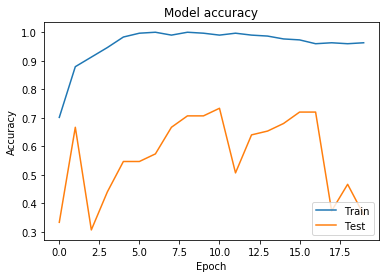

위치-나무-정중앙


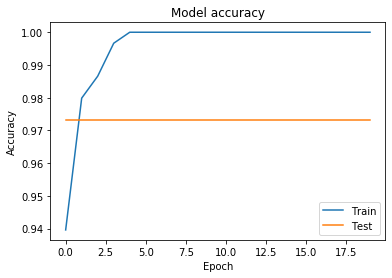

위치-나무-아래


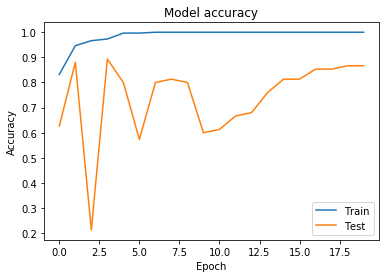

위치-나무-위


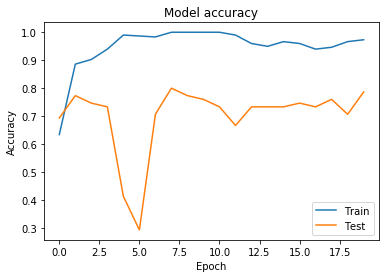

절단-나무-위


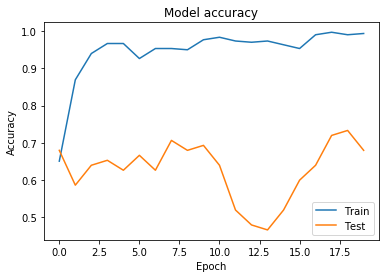

절단-나무-오른쪽


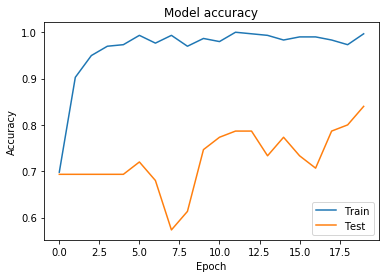

가지-아래로 늘어진 가지


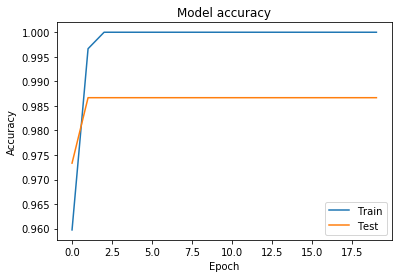

수관-공 모양


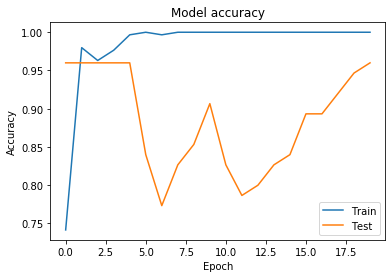

기둥-옹이구멍 안 동물


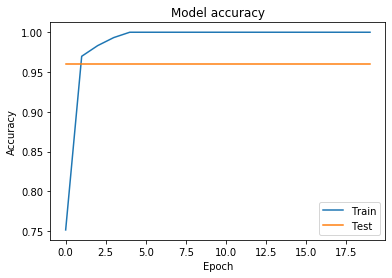

가지-부재


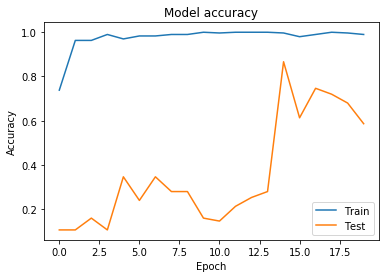

뿌리-부재2


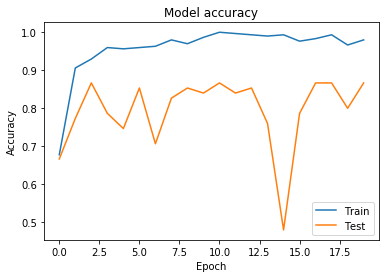

가지-옆으로 벌어짐


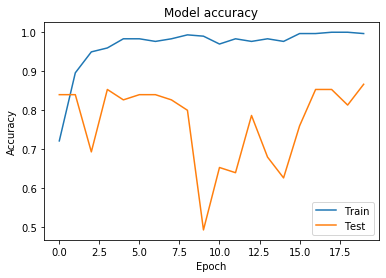

기둥-상처, 옹이구멍


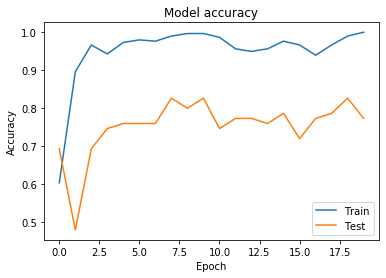

In [16]:
for i in range(len(tree)):
        print(tree[i])
        plt.plot(history[i].history['acc'])
        plt.plot(history[i].history['val_acc'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='lower right')
        plt.show()

크기-나무-크다


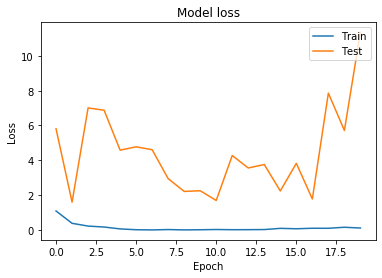

위치-나무-정중앙


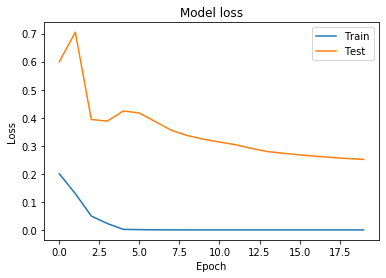

위치-나무-아래


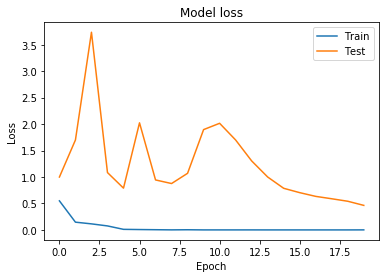

위치-나무-위


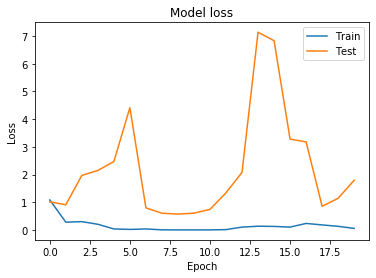

절단-나무-위


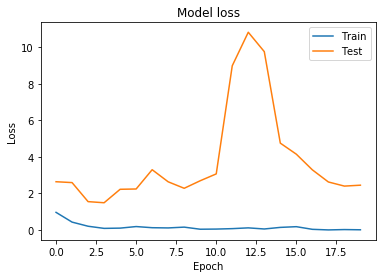

절단-나무-오른쪽


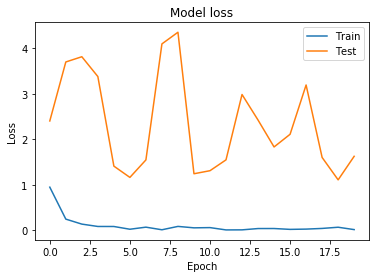

가지-아래로 늘어진 가지


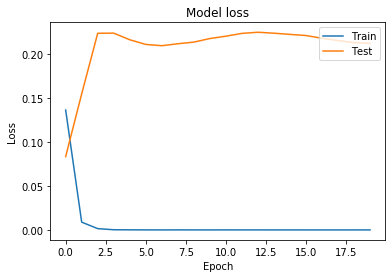

수관-공 모양


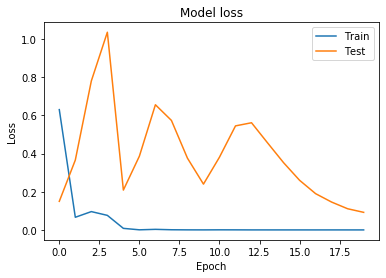

기둥-옹이구멍 안 동물


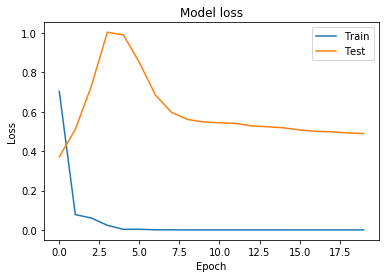

가지-부재


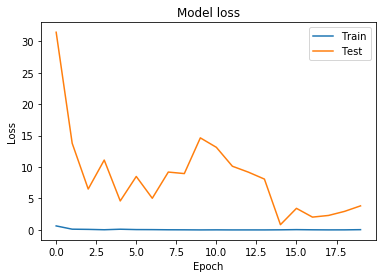

뿌리-부재2


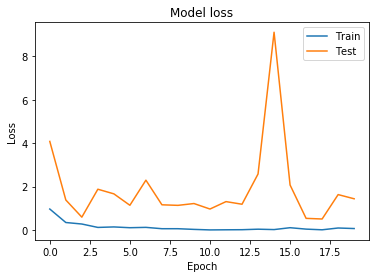

가지-옆으로 벌어짐


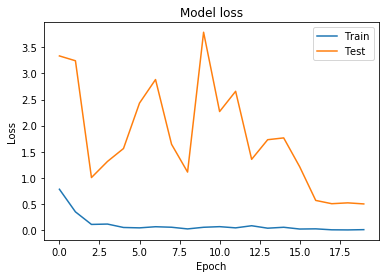

기둥-상처, 옹이구멍


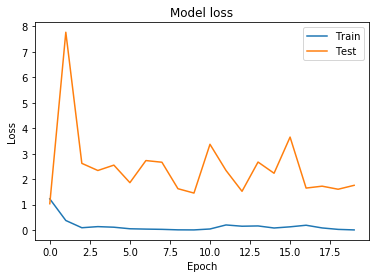

In [17]:
for i in range(len(tree)):
        print(tree[i])
        plt.plot(history[i].history['loss'])
        plt.plot(history[i].history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper right')
        plt.show()

In [18]:
model_list = []
for num, h in enumerate(tree):
    model_list.append(sorted([i for i in os.listdir() if h in i]))
    print(model_list[num])

['크기-나무-크다_mobile_model_0.33_5.8120.h5', '크기-나무-크다_mobile_model_0.67_1.5981.h5']
['위치-나무-정중앙_mobile_model_0.97_0.2513.h5', '위치-나무-정중앙_mobile_model_0.97_0.2545.h5', '위치-나무-정중앙_mobile_model_0.97_0.2584.h5', '위치-나무-정중앙_mobile_model_0.97_0.2628.h5', '위치-나무-정중앙_mobile_model_0.97_0.2674.h5', '위치-나무-정중앙_mobile_model_0.97_0.2733.h5', '위치-나무-정중앙_mobile_model_0.97_0.2793.h5', '위치-나무-정중앙_mobile_model_0.97_0.2905.h5', '위치-나무-정중앙_mobile_model_0.97_0.3038.h5', '위치-나무-정중앙_mobile_model_0.97_0.3133.h5', '위치-나무-정중앙_mobile_model_0.97_0.3234.h5', '위치-나무-정중앙_mobile_model_0.97_0.3362.h5', '위치-나무-정중앙_mobile_model_0.97_0.3552.h5', '위치-나무-정중앙_mobile_model_0.97_0.3859.h5', '위치-나무-정중앙_mobile_model_0.97_0.3879.h5', '위치-나무-정중앙_mobile_model_0.97_0.3937.h5', '위치-나무-정중앙_mobile_model_0.97_0.5994.h5']
['위치-나무-아래_mobile_model_0.63_0.9996.h5', '위치-나무-아래_mobile_model_0.80_0.7897.h5', '위치-나무-아래_mobile_model_0.81_0.7043.h5', '위치-나무-아래_mobile_model_0.81_0.7867.h5', '위치-나무-아래_mobile_model_0.85_0.5888.h5', '위치-나무-아래_mobile_mod

In [19]:
prediction = []
for i, h in enumerate(tree):
    model = MakeMobileModel()
    model.load_weights(model_list[i][-1])
    test_generator[i].reset()
    print()
    prediction.append(model.predict_generator(
        generator = test_generator[i],
        steps = get_steps(nb_test_samples[i], batch_size),
        verbose = 1
        ))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



3/3 [==============================] - 5s 2s/step

3/3 [==============================] - 5s 2s/step

3/3 [==============================] - 5s 2s/step

3/3 [==============================] - 5s 2s/step

3/3 [==============================] - 6s 2s/step

3/3 [==============================] - 6s 2s/step

3/3 [==============================] - 6s 2s/step

3/3 [==============================] - 6s 2s/step

3/3 [==============================] - 6s 2s/step

3/3 [==============================] - 6s 2s/step

3/3 [==============================] - 7s 2s/step

3/3 [==============================] - 7s 2s/step

3/3 [==============================] - 7s 2s/step


In [20]:
for i, h in enumerate(tree):
    predicted_class_indices=np.argmax(prediction[i], axis=1)
    print(len(predicted_class_indices))
    print('df_test', df_test[i].shape)
    print('prediction' , prediction[i].shape)
    print('='*10)
    
    labels = (train_generator[i].class_indices)
    labels = dict((v,k) for k,v in labels.items())
    predictions = [labels[k] for k in predicted_class_indices]
    submission = pd.read_excel(os.path.join(DATA_PATH,'sub_' + h + '.xlsx'))
    # print(submission)
    # print(len(predictions))
    submission[h + '_class'] = predictions
    print(submission.head(10))
    submission.to_excel('h_' + h + '_submission.xlsx', index=False)
    print('='*20)

94
df_test (94, 1)
prediction (94, 2)
   Unnamed: 0        data  크기-나무-크다 크기-나무-크다_class
0         433  0502_T.jpg         1              0
1          71  0072_T.jpg         0              0
2           7  0008_T.jpg         1              1
3         352  0421_T.jpg         1              0
4         444  0513_T.jpg         1              0
5         112  0114_T.jpg         1              1
6         117  0119_T.jpg         0              0
7         333  0402_T.jpg         1              1
8         357  0426_T.jpg         1              1
9         432  0501_T.jpg         1              0
94
df_test (94, 1)
prediction (94, 2)
   Unnamed: 0        data  위치-나무-정중앙 위치-나무-정중앙_class
0         442  0511_T.jpg          0               0
1         324  0393_T.jpg          0               0
2         159  0182_T.jpg          0               0
3         269  0312_T.jpg          0               0
4         101  0102_T.jpg          0               0
5         355  0424_T.jpg          0         

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

In [0]:
def micro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right',
             rotation_mode='anchor')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()
    return ax

크기-나무-크다 : 0.648936170212766
Confusion matrix, without normalization
[[22  7]
 [26 39]]


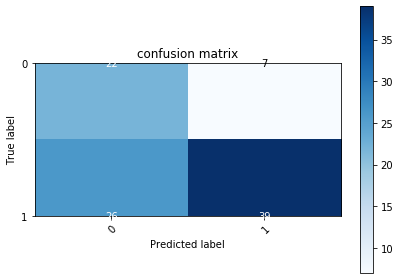

위치-나무-정중앙 : 0.9787234042553191
Confusion matrix, without normalization
[[92  0]
 [ 2  0]]


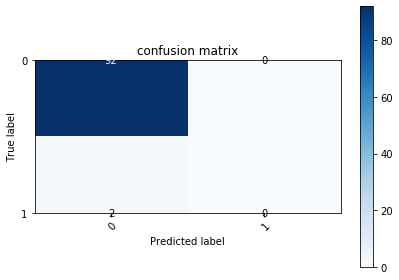

위치-나무-아래 : 0.8936170212765957
Confusion matrix, without normalization
[[76  7]
 [ 3  8]]


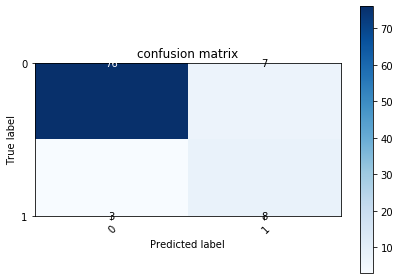

위치-나무-위 : 0.723404255319149
Confusion matrix, without normalization
[[12 12]
 [14 56]]


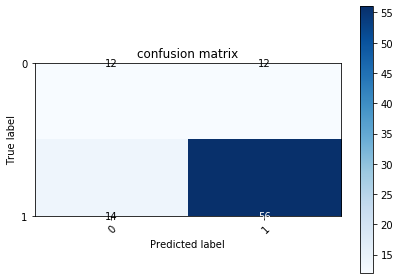

절단-나무-위 : 0.6170212765957447
Confusion matrix, without normalization
[[ 8 36]
 [ 0 50]]


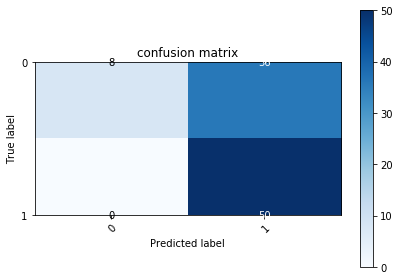

절단-나무-오른쪽 : 0.8297872340425532
Confusion matrix, without normalization
[[58  8]
 [ 8 20]]


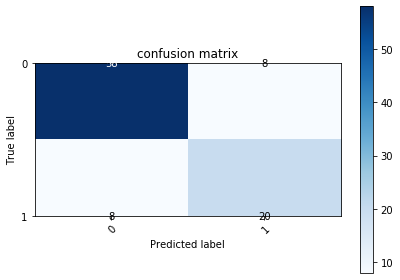

가지-아래로 늘어진 가지 : 0.9787234042553191
Confusion matrix, without normalization
[[92  1]
 [ 1  0]]


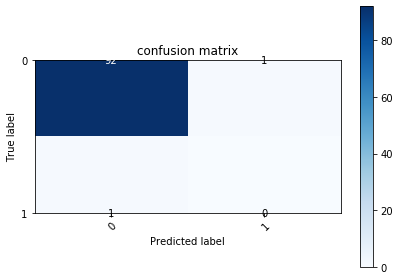

수관-공 모양 : 0.9574468085106385
Confusion matrix, without normalization
[[90  0]
 [ 4  0]]


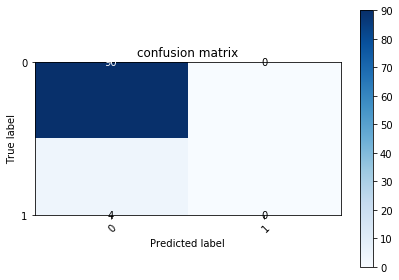

기둥-옹이구멍 안 동물 : 0.9680851063829787
Confusion matrix, without normalization
[[91  0]
 [ 3  0]]


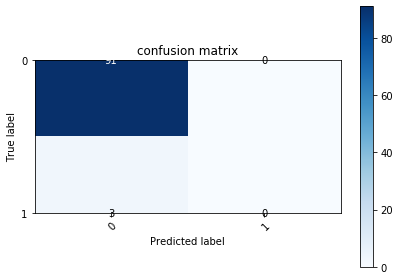

가지-부재 : 0.8191489361702128
Confusion matrix, without normalization
[[70 15]
 [ 2  7]]


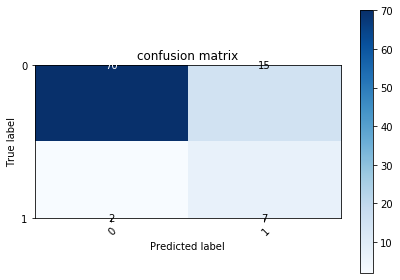

뿌리-부재2 : 0.8297872340425532
Confusion matrix, without normalization
[[41 10]
 [ 6 37]]


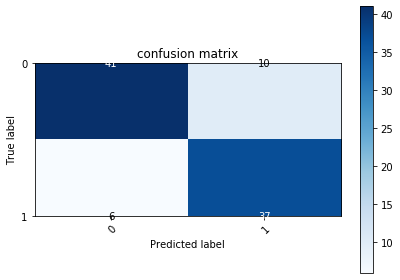

가지-옆으로 벌어짐 : 0.8297872340425532
Confusion matrix, without normalization
[[74  5]
 [11  4]]


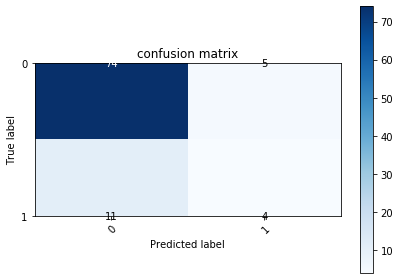

기둥-상처, 옹이구멍 : 0.6170212765957447
Confusion matrix, without normalization
[[29 19]
 [17 29]]


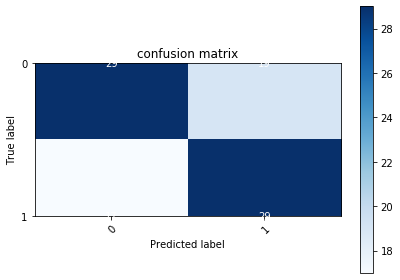

In [36]:
for h in tree:
    try:
        submission = pd.read_excel('h_'+h+'_submission.xlsx')
        print(h, ':', micro_f1(submission[h], submission[h + '_class']))
        plot_confusion_matrix(submission[h],submission[h+'_class'], classes=[0,1],
                              title='confusion matrix')
    except Exception:
        print(e)

In [0]:
def ConfusionMatrix(excel, h):
    TP, FN, FP, TN = 0, 0, 0, 0
    actual = excel[h]
    predicted = excel[h +'_class']

    for i in range(len(excel)):
        if(actual[i] == predicted[i]):
            if actual[i] == 1:
                TP = TP + 1
            else:
                TN = TN + 1
        else:
            if actual[i] == 1:
                FN = FN + 1
            else:
                FP = FP + 1
    FN = len(actual) - TP
    TN = len(predicted) - FP

    precision = TP / (TP + FP)
    neg_pred = TN / (TN + FN)
    sensi = TP / (TP + FN)
    spec = TN / (TN + FP)
    Accu = (TP+TN) / (TP+TN+FP+FN)

    return TP, FP, FN, TN, precision, neg_pred, sensi, spec, Accu

In [0]:
bestfeatures = ['가지-아래로 늘어진 가지',
                '위치-나무-아래',
                '가지-옆으로 벌어짐'
                ]

In [43]:
for h in bestfeatures:
    excel = pd.read_excel('./h_'+h+'_submission.xlsx')
    TP, FP, FN, TN, precision, neg_pred, sensi, spec, Accu = ConfusionMatrix(excel, h)
    print(h, '- confusion Matrix')
    print('='*20)
    print('actual : ', len(excel[h]))
    print('predictive : ', len(excel[h + '_class']))
    print('True Positive(TP) : ', TP)
    print('False Positive(FP) : ', FP)
    print('Flase Negative(FN) : ', FN)
    print('True Negative(TN) : ', TN)
    print('precision : ', precision)
    print('negative_predictive_values : ', neg_pred)
    print('sensitivity : ', sensi)
    print('specificity : ', spec)
    print('Accuracy : ', Accu)
    print('f1 score : ', micro_f1(excel[h], excel[h+ '_class']))
    print('='*40)

가지-아래로 늘어진 가지 - confusion Matrix
actual :  94
predictive :  94
True Positive(TP) :  0
False Positive(FP) :  1
Flase Negative(FN) :  94
True Negative(TN) :  93
precision :  0.0
negative_predictive_values :  0.49732620320855614
sensitivity :  0.0
specificity :  0.9893617021276596
Accuracy :  0.4946808510638298
f1 score :  0.9787234042553191
위치-나무-아래 - confusion Matrix
actual :  94
predictive :  94
True Positive(TP) :  8
False Positive(FP) :  7
Flase Negative(FN) :  86
True Negative(TN) :  87
precision :  0.5333333333333333
negative_predictive_values :  0.5028901734104047
sensitivity :  0.0851063829787234
specificity :  0.925531914893617
Accuracy :  0.5053191489361702
f1 score :  0.8936170212765957
가지-옆으로 벌어짐 - confusion Matrix
actual :  94
predictive :  94
True Positive(TP) :  4
False Positive(FP) :  5
Flase Negative(FN) :  90
True Negative(TN) :  89
precision :  0.4444444444444444
negative_predictive_values :  0.4972067039106145
sensitivity :  0.0425531914893617
specificity :  0.9468085